In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import pandas as pd
import itertools
import matplotlib
import os
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio import SeqUtils
import matplotlib.cm as cm
from ete3 import NCBITaxa
import re
import fileinput

The idea of the scritp is to use the output of xxxxxxF.gcoords from the v8_1_ph_p_on_p_nucmer.sh script. These will be simplified by calculating the cumsum for each pwh contig hit. The p_woh will be renamed to generate a name association with its best pwh hit. The new name will be pwh_pwoh.

In [32]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font) #changes font of the plot
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }


In [ ]:
#THIS script still needs to be fixed for the cases where mummer alignment ends overlap OR NOT

In [33]:
#define working directory
file_path = "/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v9_1/v91_cns/nucmer_pwoh_on_pwh/"
genome_prefix= "v91_cns_ph_ctg"
pwoh_fn = genome_prefix+"_pwoh_ctg.fa"
pwh_contigs_fn = genome_prefix+'_pwh_ctg.fa' #file that contains all pwh
pwoh_rn_g_fn = genome_prefix+"_pwoh_ctg_gng.fa" #for the rename with -g in mummer
pwoh_rn_r_fn = genome_prefix+"_pwoh_ctg_rng.fa" # for rename with -r in mummer
h_fn = genome_prefix+'_a_ctg.fa'

In [89]:
#here enter dir and files names pointing to the 
h_on_p_fp = "/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v9_1/v91_cns/nucmer_h_on_pwh/"
p_and_h_fp = '/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v9_1/'
p_and_h_fn = genome_prefix + ".fa"

In [34]:
os.chdir(file_path)

In [35]:
#get all the .gcoords files
file_handler = os.walk(file_path, topdown=False)
gcoords_files = [x for x in list(file_handler)[-1][2] if x[-7:]== 'gcoords']
pwoh_rn_dic_r ={} #dic for renaming pwoh
pwoh_rn_dic_g ={} #dic for renaming pwoh
#hit_summary_df = pd.DataFrame(columns=['pwoh', 'best hit p', 'pwoh len', '%len hit', '%ID']) #summary dataframe that indicates best hit for each pwoh, 

In [36]:
#make dataframe of initial query file pwoh_fn
handle_1 = open(pwoh_fn)
contigs = SeqIO.parse(handle_1, 'fasta')
contig_length = []
contig_id =[]
for x in contigs:
    if len(x.seq) != 0:
        contig_id.append(x.id)
        contig_length.append(len(x.seq))
s1 = pd.Series(contig_id, name='ID')
s2 = pd.Series(contig_length, name='Length')
pwoh_df = pd.concat([s1, s2], axis=1)
handle_1.close()

In [50]:
def pwoh_on_p_hit_summary_and_renamin(coord_files, indir ):
    """
    here pull in each gcoords file and define the longest p_wh hit on each p_woh. Save summary results in new data frame
    and generate renaming dictonary
    rename outfile for hit summary df
    return renaming dictionary and hit_summary_df
    """
    gcoords_files = coord_files
    file_path = indir
    name_list = []
    len_list=[]
    rel_len_list=[]
    pc_ID_list=[] #percentage identity
    best_hit_list=[]
    pwoh_rn_dic ={}
    for x in gcoords_files:
        ID=''
        #print(x)
        #get the length of the file name 
        _len=len(x.split('.')[0])
        #for ID use only the prefix of the file and get the ID straight by replacing the '_' with '|' to match 
        #fasta headers of input file later
        ID=x.split('.')[0].replace("_","|")
        best_hit = ''
        mummer_df_tmp = ''
        #pull in the mummer file
        mummer_df_tmp = pd.read_csv(file_path+'/'+x, sep='\t', header=None,skiprows=4 )
        header_mum = ["S1","E1","S2", "E2","LEN 1", "LEN 2", "% IDY", "ID-p", "ID-pwoh"]
        rename = dict(zip(mummer_df_tmp.columns, header_mum))
        mummer_df_tmp.rename(columns=rename,inplace=True)
        #till here it reads in the gcoords_files as a dataframe
        best_hit = mummer_df_tmp.groupby('ID-p')['LEN 1'].sum().sort_values().index[-1] #this gets the p_wh that has the highest coverage in length
        best_hit_list.append(best_hit)
        best_df =''
        best_df  = mummer_df_tmp[mummer_df_tmp['ID-p'] == best_hit] #gets a subset of the df for the best hit. Required to caclulate the rel%
        best_df['rel %'] = best_df['LEN 2']*best_df['% IDY']
        pc_ID_list.append(best_df['rel %'].sum()/best_df['LEN 2'].sum())
        #up to here the %_ID is calcuated for the best hit
        name_list.append(ID)
        len_list.append(pwoh_df.loc[pwoh_df['ID']==ID,'Length'].sum())
        rel_len_list.append(best_df['LEN 2'].sum()/pwoh_df.loc[pwoh_df['ID']==ID,'Length'].sum()*100)
        pwoh_rn_dic[ID]=best_hit+'_'+ID
    hit_summary_df_gcoords = pd.concat([pd.Series(name_list), pd.Series(best_hit_list), pd.Series(len_list), pd.Series(rel_len_list), pd.Series(pc_ID_list)],axis=1, keys=['p_woh', 'best hit p_wh', 'p_woh len', '%len hit', '%ID'])
    hit_summary_df_gcoords['%len hit'] = hit_summary_df_gcoords['%len hit'].round(2)
    hit_summary_df_gcoords['%ID'] = hit_summary_df_gcoords['%ID'].round(2)
    return pwoh_rn_dic, hit_summary_df_gcoords

In [47]:
#here pull in each gcoords file and define the longest p_wh hit on each p_woh. Save summary results in new data frame
#and generate renaming dictonary
#rename outfile for hit summary df
name_list = []
len_list=[]
rel_len_list=[]
pc_ID_list=[] #percentage identity
best_hit_list=[]
for x in gcoords_files:
    ID=''
    #print(x)
    #get the length of the file name 
    _len=len(x.split('.')[0])
    #for ID use only the prefix of the file and get the ID straight by replacing the '_' with '|' to match 
    #fasta headers of input file later
    ID=x.split('.')[0].replace("_","|")
    best_hit = ''
    mummer_df_tmp = ''
    #pull in the mummer file
    mummer_df_tmp = pd.read_csv(file_path+'/'+x, sep='\t', header=None,skiprows=4 )
    header_mum = ["S1","E1","S2", "E2","LEN 1", "LEN 2", "% IDY", "ID-p", "ID-pwoh"]
    rename = dict(zip(mummer_df_tmp.columns, header_mum))
    mummer_df_tmp.rename(columns=rename,inplace=True)
    #till here it reads in the gcoords_files as a dataframe
    best_hit = mummer_df_tmp.groupby('ID-p')['LEN 1'].sum().sort_values().index[-1] #this gets the p_wh that has the highest coverage in length
    best_hit_list.append(best_hit)
    best_df =''
    best_df  = mummer_df_tmp[mummer_df_tmp['ID-p'] == best_hit] #gets a subset of the df for the best hit. Required to caclulate the rel%
    best_df['rel %'] = best_df['LEN 2']*best_df['% IDY']
    pc_ID_list.append(best_df['rel %'].sum()/best_df['LEN 2'].sum())
    #up to here the %_ID is calcuated for the best hit
    name_list.append(ID)
    len_list.append(pwoh_df.loc[pwoh_df['ID']==ID,'Length'].sum())
    rel_len_list.append(best_df['LEN 2'].sum()/pwoh_df.loc[pwoh_df['ID']==ID,'Length'].sum()*100)
    pwoh_rn_dic_g[ID]=best_hit+'_'+ID
hit_summary_df_gcoords = pd.concat([pd.Series(name_list), pd.Series(best_hit_list), pd.Series(len_list), pd.Series(rel_len_list), pd.Series(pc_ID_list)],axis=1, keys=['p_woh', 'best hit p_wh', 'p_woh len', '%len hit', '%ID'])
hit_summary_df_gcoords['%len hit'] = hit_summary_df_gcoords['%len hit'].round(2)
hit_summary_df_gcoords['%ID'] = hit_summary_df_gcoords['%ID'].round(2)
hit_summary_df_gcoords.to_csv(file_path+genome_prefix+'_p_woh_on_p_wh_best_hit_summary_gcoords.csv', index=False)
#pwoh_rn_dic

/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [43]:
#get all the .gcoords files
file_handler = os.walk(file_path, topdown=False)
rcoords_files = [x for x in list(file_handler)[-1][2] if x[-7:]== 'rcoords']
#hit_summary_df = pd.DataFrame(columns=['pwoh', 'best hit p', 'pwoh len', '%len hit', '%ID']) #summary dataframe that indicates best hit for each pwoh, 

In [53]:
pwoh_rn_dic_r, hit_summary_df_rcoords = pwoh_on_p_hit_summary_and_renamin(rcoords_files, file_path)
hit_summary_df_rcoords.to_csv(file_path+genome_prefix+'_p_woh_on_p_wh_best_hit_summary_rcoords.csv', index=False)

/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [57]:
#do a comparison where -r and -g option in mummer give a different mapping result if at all
g_and_r_diff =[]
count = 0
for g in pwoh_rn_dic_g.keys():
    if pwoh_rn_dic_g[g] != pwoh_rn_dic_r[g]:
            g_and_r_diff.append(g)
            print("This primary contig %s is differently asigned as %s or %s" % (g, pwoh_rn_dic_g[g],pwoh_rn_dic_r[g]))
    else:
        count += 1
if count == len(pwoh_rn_dic_r):
    print ("The best hits for g and r mapping is all the same!")

The best hits for g and r mapping is all the same!


In [113]:
#all pwoh with hit
set(hit_summary_df_gcoords['best hit p_wh'].tolist())

{'000001F|quiver',
 '000003F|quiver',
 '000004F|quiver',
 '000006F|quiver',
 '000008F|quiver',
 '000009F|quiver',
 '000010F|quiver',
 '000012F|quiver',
 '000014F|quiver',
 '000016F|quiver',
 '000017F|quiver',
 '000018F|quiver',
 '000019F|quiver',
 '000020F|quiver',
 '000021F|quiver',
 '000022F|quiver',
 '000023F|quiver',
 '000027F|quiver',
 '000028F|quiver',
 '000030F|quiver',
 '000031F|quiver',
 '000033F|quiver',
 '000034F|quiver',
 '000037F|quiver',
 '000039F|quiver',
 '000040F|quiver',
 '000041F|quiver',
 '000042F|quiver',
 '000043F|quiver',
 '000045F|quiver',
 '000047F|quiver',
 '000048F|quiver',
 '000049F|quiver',
 '000050F|quiver',
 '000052F|quiver',
 '000054F|quiver',
 '000056F|quiver',
 '000057F|quiver',
 '000058F|quiver',
 '000060F|quiver',
 '000064F|quiver',
 '000065F|quiver',
 '000066F|quiver',
 '000069F|quiver',
 '000072F|quiver',
 '000073F|quiver',
 '000074F|quiver',
 '000080F|quiver',
 '000083F|quiver',
 '000088F|quiver',
 '000089F|quiver',
 '000095F|quiver',
 '000096F|qu

In [112]:
#all pwoh with hit
len(set(hit_summary_df_gcoords['best hit p_wh'].tolist()))

62

In [58]:
hit_summary_df_gcoords.head()

,p_woh,best hit p_wh,p_woh len,%len hit,%ID
0,000015F|quiver,000006F|quiver,65823,28.67,99.60
1,000024F|quiver,000023F|quiver,64141,33.31,99.84
2,000038F|quiver,000054F|quiver,86460,71.33,97.24
3,000051F|quiver,000008F|quiver,224201,9.47,99.43
4,000053F|quiver,000050F|quiver,61622,41.70,95.00


In [72]:
short_prefix = genome_prefix.split('_')[0] +'_' +genome_prefix.split('_')[1]

In [59]:
for g in g_and_r_diff:
    print(g, hit_summary_df_gcoords[hit_summary_df_gcoords['p_woh']==g]['%len hit'].sum(),hit_summary_df_rcoords[hit_summary_df_rcoords['p_woh']==g]['%len hit'].sum())

In [76]:
#rename p_woh to hs based on rcoords without filter
p_woh_list =[]
for p_woh in SeqIO.parse(pwoh_fn, 'fasta'):
    tmp_id =''
    tmp_seq=''
    tmp_id = pwoh_rn_dic_g[p_woh.id]
    tmp_seq = p_woh.seq
    p_woh_list.append(SeqRecord(tmp_seq, id=tmp_id, description=''))
SeqIO.write(p_woh_list, short_prefix+'_rcoords_all_ph_ctg_pwoh_ctg.fa', 'fasta')
rn_fn = [pwh_contigs_fn, pwoh_rn_r_fn, h_fn]
with open(short_prefix+'_rcoords_all_ph_ctg.fa', 'w') as fout, fileinput.input(rn_fn) as fin:
    for line in fin:
        fout.write(line)

In [77]:
#rename p_woh to hs based on gcoords without filter
p_woh_list =[]
for p_woh in SeqIO.parse(pwoh_fn, 'fasta'):
    tmp_id =''
    tmp_seq=''
    tmp_id = pwoh_rn_dic_g[p_woh.id]
    tmp_seq = p_woh.seq
    p_woh_list.append(SeqRecord(tmp_seq, id=tmp_id, description=''))
SeqIO.write(p_woh_list, short_prefix+'_gcoords_all_ph_ctg_pwoh_ctg.fa', 'fasta')
rn_fn = [pwh_contigs_fn, pwoh_rn_g_fn, h_fn]
with open(short_prefix+'_gcoords_all_ph_ctg.fa', 'w') as fout, fileinput.input(rn_fn) as fin:
    for line in fin:
        fout.write(line)

In [91]:
#make dataframe of initial h contigs
handle_2 = open(p_and_h_fp+p_and_h_fn)
h_contigs = SeqIO.parse(handle_2, 'fasta')
h_contig_length = []
h_contig_id =[]
for y in h_contigs:
    if '_' in list(y.id):
        h_contig_id.append(y.id)
        h_contig_length.append(len(y.seq))
s3 = pd.Series(h_contig_id, name='ID')
s4 = pd.Series(h_contig_length, name='Length')
h_df = pd.concat([s3, s4], axis=1)
handle_2.close()

In [92]:
os.chdir(h_on_p_fp)

In [93]:
!pwd

/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v9_1/v91_cns/nucmer_h_on_pwh


In [96]:
fh_2 = os.walk(h_on_p_fp, topdown=False)
h_gcoords_files = [x for x in list(fh_2)[-1][2] if x[-7:]== 'gcoords']

In [97]:
len(h_gcoords_files)

102

In [107]:
#make a summary data frame that provides the % of mapping hits and % of ID for each h on p_wh mapping
h_len =[]
h_id = []
p_id = []
h_pc_len = []
h_pc_id =[]
# up to here initiate the list that will make the dataframe at the end
for h in h_gcoords_files:
    #read in each mummer gcoords file and make df out of it
    mummer_df_tmp =""
    mummer_df_tmp = pd.read_csv(h_on_p_fp+'/'+h, sep='\t', header=None,skiprows=4 )
    header_mum = ["S1","E1","S2", "E2","LEN 1", "LEN 2", "% IDY", "ID-p", "ID-h"]
    rename = dict(zip(mummer_df_tmp.columns, header_mum))
    mummer_df_tmp.rename(columns=rename,inplace=True)
    h_ctg_list = list(set(mummer_df_tmp["ID-h"].tolist()))
    #get all h_ctgs for each p_ctg
    for h_sub in h_ctg_list:
        #calculate pc_id and pc_len for each hapolitg aligning to the primary contig
        sub_df = ''
        pc_length = ''
        sub_pc_id =''
        h_id.append(h_sub) #add the id to the list
        sub_df = mummer_df_tmp[mummer_df_tmp['ID-h'] == h_sub] #get the df concerning only the current h_ctg
        sub_df
        p_id.append(sub_df['ID-p'].tolist()[0])
        h_len.append(h_df[h_df['ID'] == h_sub]['Length'].sum())
        h_sub_length = sub_df['LEN 2'].sum() #get the aligned length
        
        if h_df[h_df['ID'] == h_sub]['Length'].sum() != 0:
            pc_length = h_sub_length/h_df[h_df['ID'] == h_sub]['Length'].sum()*100 #calculate the pc_length
        else:
            next
        
        h_pc_len.append(pc_length)
        sub_df["rel %"] = sub_df['LEN 2']*sub_df['% IDY']
        sub_pc_id = sub_df["rel %"].sum()/h_sub_length #calculate the relative identity
        h_pc_id.append(sub_pc_id)
h_on_p_summary_df = pd.concat([pd.Series(h_id), pd.Series(p_id), pd.Series(h_len), pd.Series(h_pc_len), pd.Series(h_pc_id)],axis=1, keys=['h-ID', 'p-ID', 'h len', '%len h_ctg hit', '%ID h'])
h_on_p_summary_df['%len h_ctg hit'] = h_on_p_summary_df['%len h_ctg hit'].round(2)
h_on_p_summary_df['%ID h'] = h_on_p_summary_df['%ID h'].round(2)
h_on_p_summary_df.to_csv(h_on_p_fp+short_prefix+'h_on_pwh_summary_gcoords.csv', index=False)

/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [110]:
#several h don't seem to have mapped on the primary contigs with the -g option
set(h_df['ID'].tolist()) - set(h_on_p_summary_df['h-ID'].tolist())

{'000003F_039|quiver',
 '000007F_018|quiver',
 '000074F_007|quiver',
 '000091F_003|quiver',
 '000185F_001|quiver',
 '000230F_001|quiver'}

In [109]:
h_on_p_summary_df.head()

,h-ID,p-ID,h len,%len h_ctg hit,%ID h
0,000000F_027|quiver,000000F|quiver,41706,78.28,99.55
1,000000F_049|quiver,000000F|quiver,17471,100.00,99.21
2,000000F_037|quiver,000000F|quiver,27343,100.00,99.77
3,000000F_057|quiver,000000F|quiver,36770,98.12,99.10
4,000000F_054|quiver,000000F|quiver,294830,81.24,98.88


In [ ]:
#several h don't seem to have mapped on the primary contigs with the -q option
len(h_on_p_summary_df)

#all seems to be alright but 000082F_001 didn't align to its primary contig with the given options of cat 
nucmer v8_1_ph_tr_ctg_000082F.fa v8_1_ph_tr_ctg_000082F_a_ctg.fa > out.delta
delta-filter -g out.delta > v8_1_ph_000082Fpap_gfiltered.delta
show-coords -T v8_1_ph_000082Fpap_gfiltered.delta > v8_1_ph_000082Fpap.gcoords
##check what is going on there

set(h_df['ID'].tolist())-set(h_on_p_summary_df['h-ID'].tolist())

h_df[h_df['ID']=='000082F_001']['Length']

/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


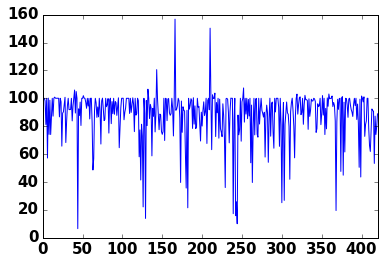

In [101]:
h_on_p_summary_df['%len h_ctg hit'].plot()

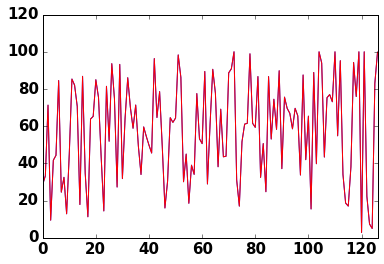

In [102]:
hit_summary_df_gcoords['%len hit'].plot()
hit_summary_df_rcoords['%len hit'].plot(c='r')

(0, 200)

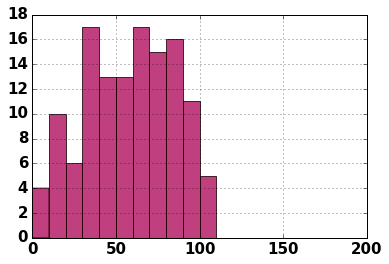

In [103]:
hit_summary_df_gcoords['%len hit'].hist(bins=20, range=(0,200), color='b', alpha=0.5)
hit_summary_df_rcoords['%len hit'].hist(bins=20, range=(0,200), color='r', alpha=0.5)
plt.xlim(0,200)

(0, 200)

/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


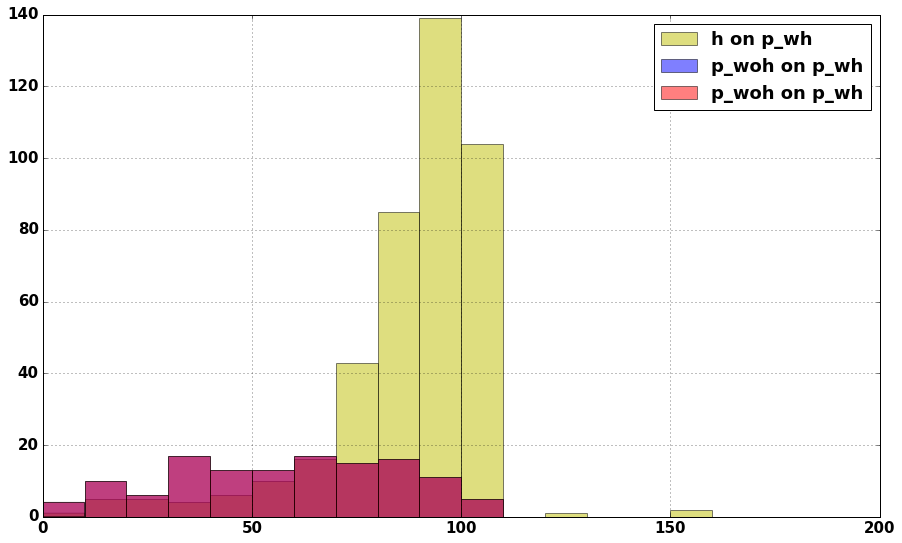

In [104]:
plt.figure(figsize=(15,9))
h_on_p_summary_df['%len h_ctg hit'].hist(bins=20, range=(0,200), color='y',alpha=0.5, label='h on p_wh')
hit_summary_df_gcoords['%len hit'].hist(bins=20, range=(0,200), color='b', alpha=0.5, label='p_woh on p_wh')
hit_summary_df_rcoords['%len hit'].hist(bins=20, range=(0,200), color='r', alpha=0.5, label='p_woh on p_wh')
plt.legend(loc=0)
plt.xlim(0,200)

(0, 100)

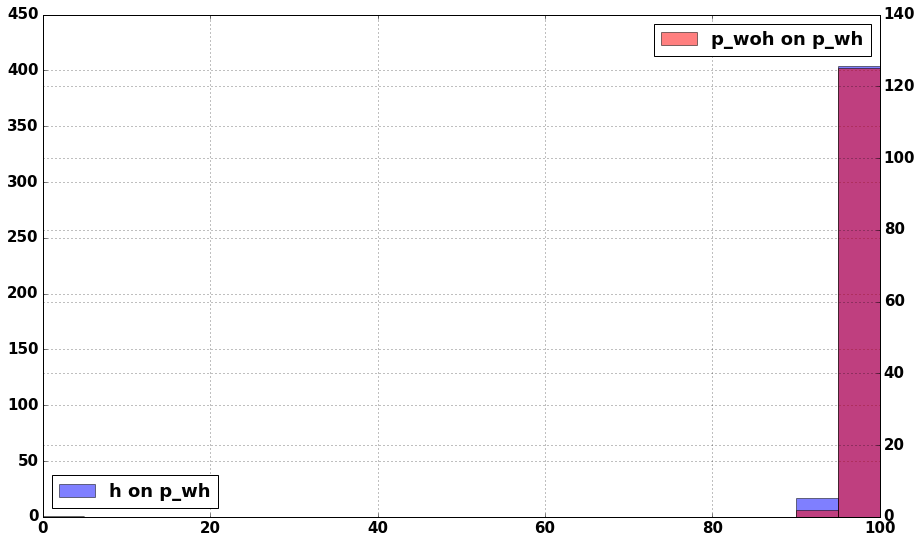

In [106]:
fig, ax1 = plt.subplots(figsize=(15,9))
h_on_p_summary_df['%ID h'].hist(bins=20, range=(0,100), alpha=0.5, label='h on p_wh' )
plt.legend(loc=3)
ax2 = ax1.twinx()
hit_summary_df_gcoords['%ID'].hist(bins=20, range=(0,100), color='r', alpha=0.5, label='p_woh on p_wh')
plt.legend(loc=0)
plt.xlim(0,100)

In [ ]:
h_on_p_summary_df.head()

In [ ]:
#once manual or later automatic curation is done use this as input to finalize naming of contigs
#requires to run the h_on_p_gcoords all notebook and script to be executed

In [116]:
curated_df = pd.read_csv(file_path+genome_prefix+'_p_woh_on_p_wh_best_hit_summary_gcoords_curated.csv')

In [117]:
curated_df.head()

,p_woh,best hit p_wh,p_woh len,%len hit,%ID,manually confirmed,comment
0,000123F|quiver,000001F|quiver,102408,64.17,97.29,yes,NaN
1,000156F|quiver,000001F|quiver,63532,89.43,98.61,yes,NaN
2,000157F|quiver,000001F|quiver,62650,28.94,95.13,no,spurious alignment at the end
3,000180F|quiver,000001F|quiver,47458,50.67,96.39,yes,NaN
4,000135F|quiver,000003F|quiver,87944,96.38,98.48,yes,check again


In [152]:
curated_df[curated_df['p_woh'] ==  '000123F|quiver'].iloc[0]['manually confirmed']

'yes'

In [163]:
def rename(df, _id):
    """
    Function to rename ids of pwoh based on a 'mannually confirmed' curated df. Requires pwoh_on_p mapping, analysis
    and h_on_p_g/rcoords mapping and curation.
    """
    df = df
    _id = _id
    df[df['p_woh'] == _id].iloc[0]['manually confirmed']
    inticator = df[df['p_woh'] == _id].iloc[0]['manually confirmed']
    if inticator == 'yes':
        name = df[df['p_woh'] == _id].iloc[0]['p_woh']+'_'+df[df['p_woh'] == _id].iloc[0]['best hit p_wh']
    else:
        name = df[df['p_woh'] == _id].iloc[0]['p_woh']
    return name

In [157]:
final_rn_dic ={}
for _id in curated_df['p_woh'].tolist():
    final_rn_dic[_id] = rename(curated_df, _id)


In [161]:
#rename p_woh to hs based on g/rcoords curated file using function rename as renamer.
os.chdir(file_path)
p_woh_list =[]
for p_woh in SeqIO.parse(pwoh_fn, 'fasta'):
    tmp_id =''
    tmp_seq=''
    tmp_id = final_rn_dic[p_woh.id]
    tmp_seq = p_woh.seq
    p_woh_list.append(SeqRecord(tmp_seq, id=tmp_id, description=''))
SeqIO.write(p_woh_list, short_prefix+'_gcoords_cur_ph_ctg_pwoh_ctg.fa', 'fasta')
rn_fn = [pwh_contigs_fn, short_prefix+'_gcoords_cur_ph_ctg_pwoh_ctg.fa', h_fn]
with open(short_prefix+'_gcoords_cur_ph_ctg.fa', 'w') as fout, fileinput.input(rn_fn) as fin:
    for line in fin:
        fout.write(line)

In [162]:
!pwd

/Users/ben/Documents/work_related/Canberra/RJ_lab_projects/Rust_genome_sequencing/PST79/analysis/PacBio_SCH1743/FALCON_0_4_assemblies/p_assemblies/v9_1/v91_cns/nucmer_pwoh_on_pwh
